## Parallel workloads archive parser

Authors of this archive wrote article where explained all problems they faced -> http://www.cs.huji.ac.il/~feit/papers/PWA14JPDC.pdf

Authors book about Workload Modeling -> http://www.cs.huji.ac.il/~feit/wlmod/wlmod.pdf

Parallel workloads archive link -> http://www.cs.huji.ac.il/labs/parallel/workload/index.html

Logs Format -> http://www.cs.huji.ac.il/labs/parallel/workload/swf.html

Logs -> http://www.cs.huji.ac.il/labs/parallel/workload/logs.html

Log Parser on Perl -> http://www.cs.huji.ac.il/labs/parallel/workload/parse_swf.pl

## Standard workload format
- **Job Number** -- a counter field, starting from 1.

- **Submit Time** -- in seconds. The earliest time the log refers to is zero, and is usually the submittal time of the first job. The lines in the log are sorted by ascending submittal times. It makes sense for jobs to also be numbered in this order.

- **Wait Time** -- in seconds. The difference between the job's submit time and the time at which it actually began to run. Naturally, this is only relevant to real logs, not to models.

- **Run Time** -- in seconds. The wall clock time the job was running (end time minus start time). We decided to use "wait time" and "run time" instead of the equivalent "start time" and "end time" because they are directly attributable to the scheduler and application, and are more suitable for models where only the run time is relevant. <font color='red'> Note that when values are rounded to an integral number of seconds (as often happens in logs) a run time of 0 is possible and means the job ran for less than 0.5 seconds. On the other hand it is permissable to use floating point values for time fields. </font>

- **Number of Allocated Processors** -- an integer. In most cases this is also the number of processors the job uses; if the job does not use all of them, we typically don't know about it.

- **Average CPU Time Used** -- both user and system, in seconds. This is the average over all processors of the CPU time used, and may therefore be smaller than the wall clock runtime. If a log contains the total CPU time used by all the processors, it is divided by the number of allocated processors to derive the average.

- **Used Memory** -- in kilobytes. This is again the average per processor.

- **Requested Number of Processors**.

- **Requested Time** -- This can be either runtime (measured in wallclock seconds), or average CPU time per processor (also in seconds) -- the exact meaning is determined by a header comment. In many logs this field is used for the user runtime estimate (or upper bound) used in backfilling. If a log contains a request for total CPU time, it is divided by the number of requested processors.

- **Requested Memory (again kilobytes per processor).**

- **Status** 1 if the job was completed, 0 if it failed, and 5 if cancelled. If information about chekcpointing or swapping is included, other values are also possible. See usage note -> (http://www.cs.huji.ac.il/labs/parallel/workload/swf.html). This field is meaningless for models, so would be -1.
    - The main usage of the status field is to note the job's status. This isn't as straightforward as it sounds. 
    - The simple case is jobs that complete normally, and have status 1.
    - The harder case is jobs that don't complete normally. This can happen for several reasons:
        - The job failed (e.g. segmentation fault). This is given status 0.
        - The job was cancelled by the user (like ^C in Unix). This is given status 5. Note that cancelled jobs may have positive runtimes and processors if cancelled after they started to run, or 0 or -1 if cancelled while waiting in the queue.
        - The job was killed by the system (e.g. because it exceeded its requested run time). This may be given different status values in different logs; it will typically be 0 or 5, but might also be 1.
        
        Note also that the distinction between failure / cancellation / killing is not necessarily accurate, as the distinction typically does not appear in the original logs. If a log contains information about checkpoints and swapping out of jobs, a job can have multiple lines in the log. In fact, we propose that the job information appear twice. First, there will be one line that summarizes the whole job: its submit time is the submit time of the job, its runtime is the sum of all partial runtimes, and its code is 0 or 1 according to the completion status of the whole job. In addition, there will be separate lines for each instance of partial execution between being swapped out. All these lines have the same job ID and appear consecutively in the log. Only the first has a submit time; the rest only have a wait time since the previous burst. The completed code for all these lines is 2, meaning "to be continued"; the completion code for the last such line is 3 or 4, corresponding to completion or being killed. It should be noted that such details are only useful for studying the behavior of the logged system, and are not a feature of the workload. Such studies should ignore lines with completion codes of 0 and 1, and only use lines with 2, 3, and 4. <font color="red">For workload studies, only the single-line summary of the job should be used, as identified by a code of 0 or 1. </font>

- **User ID** -- a natural number, between one and the number of different users.

- **Group ID** -- a natural number, between one and the number of different groups. Some systems control resource usage by groups rather than by individual users.

- **Executable (Application) Number** -- a natural number, between one and the number of different applications appearing in the workload. In some logs, this might represent a script file used to run jobs rather than the executable directly; this should be noted in a header comment.

- **Queue Number** -- a natural number, between one and the number of different queues in the system. The nature of the system's queues should be explained in a header comment. This field is where batch and interactive jobs should be differentiated: we suggest the convention of denoting interactive jobs by 0.

- **Partition Number** -- a natural number, between one and the number of different partitions in the systems. The nature of the system's partitions should be explained in a header comment. For example, it is possible to use partition numbers to identify which machine in a cluster was used.

- **Preceding Job Number** -- this is the number of a previous job in the workload, such that the current job can only start after the termination of this preceding job. Together with the next field, this allows the workload to include feedback as described below.

- **Think Time from Preceding Job** -- this is the number of seconds that should elapse between the termination of the preceding job and the submittal of this one.


## Header Comments
- **Version**: Version number of the standard format the file uses. The format described here is version 2.
- **Computer**: Brand and model of computer
- **Installation**: Location of installation and machine name
- **Acknowledge**: Name of person(s) to acknowledge for creating/collecting the workload.
- **Information**: Web site or email that contain more information about the workload or installation.
- **Conversion**: Name and email of whoever converted the log to the standard format.
- **MaxJobs**: Integer, total number of jobs in this workload file.
- **MaxRecords**: Integer, total number of records in this workload file. If no checkpointing/swapping information is included, there is one record per job, and this is equal to MaxJobs. But with chekpointing/swapping there may be multiple records per job.
- **Preemption**: Enumerated, with four possible values. 'No' means that jobs run to completion, and are represented by a single line in the file. 'Yes' means that the execution of a job may be split into several parts, and each is represented by a separate line. 'Double' means that jobs may be split, and their information appears twice in the file: once as a one-line summary, and again as a sequence of lines representing the parts, as suggested above. 'TS' means time slicing is used, but no details are available.
- **UnixStartTime**: When the log starts, in Unix time (seconds since the epoch)
- **TimeZone**: DEPRECATED and replaced by TimeZoneString.
- A value to add to times given as seconds since the epoch. The sum can then be fed into gmtime (Greenwich time function) to get the correct date and hour of the day. The default is 0, and then gmtime can be used directly. - Note: do not use localtime, as then the results will depend on the difference between your time zone and the installation time zone.
- **TimeZoneString**: Replaces the buggy and now deprecated TimeZone. TimeZoneString is a standard UNIX string indicating the time zone in which the log was generated; this is actually the name of a zoneinfo file, e.g. "Europe/Paris". All times within the SWF file are in this time zone. For more details see the usage note below.
- **StartTime**: When the log starts, in human readable form, in this standard format: Tue Feb 21 18:44:15 IST 2006 (as printed by the UNIX 'date' utility).
- **EndTime**: When the log ends (the last termination), formatted like StartTime.
- **MaxNodes**: Integer, number of nodes in the computer. List the number of nodes in different partitions in parentheses if applicable.
- **MaxProcs**: Integer, number of processors in the computer. This is different from MaxNodes if each node is an SMP. List the number of processors in different partitions in parentheses if applicable.
- **MaxRuntime**: Integer, in seconds. This is the maximum that the system allowed, and may be larger than any specific job's runtime in the workload.
- **MaxMemory**: Integer, in kilobytes. Again, this is the maximum the system allowed.
- **AllowOveruse**: Boolean. 'Yes' if a job may use more than it requested for any resource, 'No' if it can't.
- **MaxQueues**: Integer, number of queues used.
- **Queues**: A verbal description of the system's queues. Should explain the queue number field (if it has known values). As a minimum it should be explained how to tell between a batch and interactive job.
- **Queue**: A description of a single queue in the following format: queue-number queue-name (optional-details). This should be repeated for all the queues.
- **MaxPartitions**: Integer, number of partitions used.
- **Partitions**: A verbal description of the system's partitions, to explain the partition number field. For example, partitions can be distinct parallel machines in a cluster, or sets of nodes with different attributes (memory configuration, number of CPUs, special attached devices), especially if this is known to the scheduler.
- **Partition**: Description of a single partition.
- **Note**: There may be several notes, describing special features of the log. For example, The runtime is until the last node was freed; jobs may have freed some of their nodes earlier

In [1]:
import os


class Job:
    FIELDS_NAME = [
        "job",
        "submit",
        "wait",
        "runtime",
        "proc used",
        "cpu used",
        "mem used",
        "proc req",
        "cpu req",
        "mem req",
        "status",
        "uid",
        "gid",
        "executable",
        "queue",
        "partition",
        "prev jobs",
        "think time"
    ]
    
    FIELDS_SIZE = [
        10, 10, 6, 6, 3, 6, 10, 3, 10, 2, 2, 2, 2, 2, 2, 2, 2, 2
    ]
    
    def __init__(self, description):
        params = description.split()

        if len(params) != len(self.FIELDS_NAME):
            raise Exception("Bad len of job description")

        self.fields = {}

        for i in range(len(params)):
            self.fields[self.FIELDS_NAME[i]] = int(float(params[i]))
    
    def pretty_print(self):
        print("===== Job Information =====")
        
        job_info = ""
        for field_name in self.FIELDS_NAME:
            job_info += "\t%s: %d\n" % (field_name, self.fields[field_name])
            
            
        print(job_info)
        
    @staticmethod
    def print_fields_name():
        max_len = max(map(len, Job.FIELDS_NAME))
        
        for i in range(max_len):
            line = ""
            for j in range(len(Job.FIELDS_NAME)):
                str_fmt = "%%%ds|" % Job.FIELDS_SIZE[j]
                ch = ""
                if (i+1) <= len(Job.FIELDS_NAME[j]):
                    ch = Job.FIELDS_NAME[j][i]
                line += str_fmt % ch

            print(line)

    def __str__(self):
        job_info = ""
        for i in range(len(self.FIELDS_NAME)):
            str_fmt = "%%%dd" % self.FIELDS_SIZE[i]
            job_info += ' ' + str_fmt % (self.fields[self.FIELDS_NAME[i]])

        return job_info


class LogFile:
    def __init__(self, path):
        self.path = path
        
        self.total_jobs = 0

        # count bad things
        self.cnt_fmt  = 0
        self.cnt_t0   = 0
        self.cnt_p0   = 0
        self.cnt_stat = 0
        self.cnt_bad  = 0

        # some useful globals
        self.start = 0
        self.timezone_str = ""
        self.max_jobs  = 0
        self.procs = 0
        self.nodes = 0
        
        self.jobs = []

    def read(self):
        file = open(self.path, "r")
        
        line = file.readline()
        while line != "":
            if line[0] == ';':
                if "UnixStartTime:" in line:
                    self.start = int(line.split(':')[1])
                elif "TimeZoneString:" in line:
                    self.timezone_str = line.split(':')[1]
                elif "MaxJobs:" in line:
                    self.max_jobs = int(line.split(':')[1])
                elif "MaxProcs:" in line:
                    self.procs = int(line.split(':')[1])
                elif "MaxNodes:" in line:
                    self.nodes = int(line.split(':')[1])

                line = file.readline()
                continue
                
            # Parse job line
            self.total_jobs += 1
            if self.total_jobs % 500000 == 0:
                print("Read '%s' jobs" % self.total_jobs)

            try:
                job = Job(line)
            except Exception as e:
                self.cnt_fmt += 1
                print("[ERROR] Cannot create job from '%s': '%s'" % (line, e))
                line = file.readline()
                continue

            if job.fields["runtime"] == 0:
                # something potentially fishy, as job took 0 time
                # but this can also be a resolution problem
                self.cnt_t0 += 1
                line = file.readline()
                continue

            if job.fields["proc used"] == 0:
                # something really fishy: job did not use any processors.
                # could mean job was cancelled before running
                self.cnt_p0 += 1
                line = file.readline()
                continue

            if job.fields["submit"] == -1 or job.fields["runtime"] == -1 or job.fields["proc used"] == -1:
                # something very fishy: job arrival, runtime or processors undefined
                self.cnt_bad += 1
                line = file.readline()
                continue
                
            if job.fields["status"] != 1:
                # another fishy:
                # job failed (status 0)
                # job was cancelled (status 5)
                # or job is only part of a whole job (status 2, 3, 4)
                self.cnt_stat += 1
                line = file.readline()
                continue

            self.jobs.append(job)
            line = file.readline()
            continue
        
        file.close()
   
    def print_jobs(self, pretty = True, amount = 10):
        print("LOG FILE '%s'" % self.path)
        Job.print_fields_name()
        
        if pretty == True:
            for i in range(0, min(len(self.jobs), amount)):
                self.jobs[i].pretty_print()
        else:
            for i in range(0, min(len(self.jobs), amount)):
                print(self.jobs[i])
                
        print('\n')
            
    def print_errors(self):
        print("Errors while read log file:")
        print("\t%d lines had a bad format" % self.cnt_fmt)
        print("\t%d jobs had 0 time" % self.cnt_t0)
        print("\t%d jobs had 0 processors" % self.cnt_p0)
        print("\t%d jobs had non-1 status" % self.cnt_stat)
        print("\t%d jobs had bad data (undefined arrival, runtime or processors)" % \
              self.cnt_bad)

    @property
    def correct_jobs(self):
        return len(self.jobs)

    
# ============================== READ LOGS ==============================
LOG_DIRECTORY="../../parallel_workload_archive/log"
LOG_FILENAMES = [
    "ANL-Intrepid-2009-1.swf",
    "CEA-Curie-2011-2.1-cln.swf",
#     "CIEMAT-Euler-2008-1.swf",
    "CTC-SP2-1995-2.swf",
    "CTC-SP2-1996-3.1-cln.swf",
    "DAS2-fs0-2003-1.swf",
    "DAS2-fs1-2003-1.swf",
    "DAS2-fs2-2003-1.swf",
    "DAS2-fs3-2003-1.swf",
    "DAS2-fs4-2003-1.swf",
    "HPC2N-2002-2.2-cln.swf",
    "Intel-NetbatchA-2012-1.swf",
    "Intel-NetbatchB-2012-1.swf",
    "Intel-NetbatchC-2012-1.swf",
    "Intel-NetbatchD-2012-1.swf",
    "KTH-SP2-1996-2.1-cln.swf",
    "LANL-CM5-1994-4.1-cln.swf",
    "LANL-O2K-1999-2.swf",
    "LCG-2005-1.swf",
    "LLNL-Atlas-2006-2.1-cln.swf",
    "LLNL-T3D-1996-2.swf",
    "LLNL-Thunder-2007-1.1-cln.swf",
    "LLNL-uBGL-2006-2.swf",
    "LPC-EGEE-2004-1.2-cln.swf",
    "METACENTRUM-2009-2.swf",
#     "METACENTRUM-2013-3.swf",
    "NASA-iPSC-1993-3.1-cln.swf",
    "OSC-Clust-2000-3.1-cln.swf",
    "PIK-IPLEX-2009-1.swf",
    "RICC-2010-2.swf",
    "SDSC-BLUE-2000-4.2-cln.swf",
    "SDSC-DS-2004-2.1-cln.swf",
    "SDSC-Par-1995-3.1-cln.swf",
    "SDSC-Par-1996-3.1-cln.swf",
    "SDSC-SP2-1998-4.2-cln.swf",
    "SHARCNET-2005-2.swf",
    "SHARCNET-Whale-2006-2.swf",
    "Sandia-Ross-2001-1.1-cln.swf",
    "UniLu-Gaia-2014-2.swf"
]

LOG_FILES = []

for filename in LOG_FILENAMES:
    path = os.path.join(LOG_DIRECTORY, filename)
    
    print("Start read '%s'" % path)
    
    if not os.path.isfile(path):
        print("[ERROR] File '%s' is not exists" % path)
        continue

    log_file = LogFile(path)
    
    try:
        log_file.read()
    except Exception as e:
#         print("[ERROR] Error while read log file '%s': %s" % (filename, e))
        continue

    log_file.print_errors()
    print("%30s was read successfully. Job statistics." % filename)
    print("\tTOTAL JOBS -> %10d\n\tCORRECT -> %10d\n\tUNIQUE -> %10d" %
          (log_file.total_jobs, log_file.correct_jobs,
           len(set(job.fields["executable"] for job in log_file.jobs))))
    
    LOG_FILES.append(log_file)

print('\n')
    
# for log_file in LOG_FILES:
#     log_file.print_jobs(pretty=True, amount=20)


Start read '../../parallel_workload_archive/log/ANL-Intrepid-2009-1.swf'
Errors while read log file:
	0 lines had a bad format
	0 jobs had 0 time
	0 jobs had 0 processors
	68936 jobs had non-1 status
	0 jobs had bad data (undefined arrival, runtime or processors)
       ANL-Intrepid-2009-1.swf was read successfully. Job statistics.
	TOTAL JOBS ->      68936
	CORRECT ->          0
	UNIQUE ->          0
Start read '../../parallel_workload_archive/log/CEA-Curie-2011-2.1-cln.swf'
Errors while read log file:
	0 lines had a bad format
	17286 jobs had 0 time
	0 jobs had 0 processors
	15549 jobs had non-1 status
	0 jobs had bad data (undefined arrival, runtime or processors)
    CEA-Curie-2011-2.1-cln.swf was read successfully. Job statistics.
	TOTAL JOBS ->     312826
	CORRECT ->     279991
	UNIQUE ->          1
Start read '../../parallel_workload_archive/log/CTC-SP2-1995-2.swf'
Start read '../../parallel_workload_archive/log/CTC-SP2-1996-3.1-cln.swf'
Start read '../../parallel_workload_archi

Read '500000' jobs
Read '1000000' jobs
Errors while read log file:
	0 lines had a bad format
	42697 jobs had 0 time
	0 jobs had 0 processors
	207627 jobs had non-1 status
	47025 jobs had bad data (undefined arrival, runtime or processors)
           SHARCNET-2005-2.swf was read successfully. Job statistics.
	TOTAL JOBS ->    1195242
	CORRECT ->     897893
	UNIQUE ->     638980
Start read '../../parallel_workload_archive/log/SHARCNET-Whale-2006-2.swf'
Read '500000' jobs
Errors while read log file:
	0 lines had a bad format
	28449 jobs had 0 time
	0 jobs had 0 processors
	127313 jobs had non-1 status
	0 jobs had bad data (undefined arrival, runtime or processors)
     SHARCNET-Whale-2006-2.swf was read successfully. Job statistics.
	TOTAL JOBS ->     589251
	CORRECT ->     433489
	UNIQUE ->     325970
Start read '../../parallel_workload_archive/log/Sandia-Ross-2001-1.1-cln.swf'
Errors while read log file:
	0 lines had a bad format
	2277 jobs had 0 time
	0 jobs had 0 processors
	44807 job

In [2]:
for log_file in LOG_FILES:
    log_file.print_jobs(pretty=False, amount=20)

LOG FILE '../../parallel_workload_archive/log/ANL-Intrepid-2009-1.swf'
         j|         s|     w|     r|  p|     c|         m|  p|         c| m| s| u| g| e| q| p| p| t|
         o|         u|     a|     u|  r|     p|         e|  r|         p| e| t| i| i| x| u| a| r| h|
         b|         b|     i|     n|  o|     u|         m|  o|         u| m| a| d| d| e| e| r| e| i|
          |         m|     t|     t|  c|      |          |  c|          |  | t|  |  | c| u| t| v| n|
          |         i|      |     i|   |     u|         u|   |         r| r| u|  |  | u| e| i|  | k|
          |         t|      |     m|  u|     s|         s|  r|         e| e| s|  |  | t|  | t| j|  |
          |          |      |     e|  s|     e|         e|  e|         q| q|  |  |  | a|  | i| o| t|
          |          |      |      |  e|     d|         d|  q|          |  |  |  |  | b|  | o| b| i|
          |          |      |      |  d|      |          |   |          |  |  |  |  | l|  | n| s| m|
          |         

In [3]:
# Find only correct files

import datetime

# good_log_files = sorted(filter(lambda log_file: len(log_file.jobs) != 0, LOG_FILES),
#                         key=lambda log_file: len(log_file.jobs))

good_log_files = sorted(filter(lambda log_file: len(log_file.jobs) != 0, LOG_FILES),
                        key=lambda log_file: 
                            max([job.fields["submit"]+
                                job.fields["wait"]+
                                job.fields["runtime"]
                                for job in log_file.jobs]) - log_file.jobs[0].fields["submit"]
                       )

for log_file in good_log_files:
    duration = max([job.fields["submit"]+
                job.fields["wait"]+
                job.fields["runtime"]
                for job in log_file.jobs]) - log_file.jobs[0].fields["submit"]

    print("name: %30s| jobs: %10d | duration: %10s" % 
          (log_file.path.split('/')[-1],
           len(log_file.jobs),
            datetime.timedelta(seconds=duration)))

name:          UniLu-Gaia-2014-2.swf| jobs:      41267 | duration: 89 days, 2:08:13
name:            LLNL-T3D-1996-2.swf| jobs:      13051 | duration: 115 days, 22:52:16
name:            LANL-O2K-1999-2.swf| jobs:      93510 | duration: 137 days, 17:51:59
name:  LLNL-Thunder-2007-1.1-cln.swf| jobs:      97875 | duration: 147 days, 14:09:25
name:                RICC-2010-2.swf| jobs:     431547 | duration: 152 days, 23:53:13
name:         METACENTRUM-2009-2.swf| jobs:      86586 | duration: 165 days, 19:37:40
name:    LLNL-Atlas-2006-2.1-cln.swf| jobs:      19949 | duration: 192 days, 22:56:13
name:      SHARCNET-Whale-2006-2.swf| jobs:     433489 | duration: 202 days, 23:13:56
name:           LLNL-uBGL-2006-2.swf| jobs:      11277 | duration: 222 days, 9:22:36
name:     CEA-Curie-2011-2.1-cln.swf| jobs:     279991 | duration: 257 days, 2:12:55
name:       KTH-SP2-1996-2.1-cln.swf| jobs:      20523 | duration: 332 days, 22:17:00
name:            SHARCNET-2005-2.swf| jobs:     897893 | d

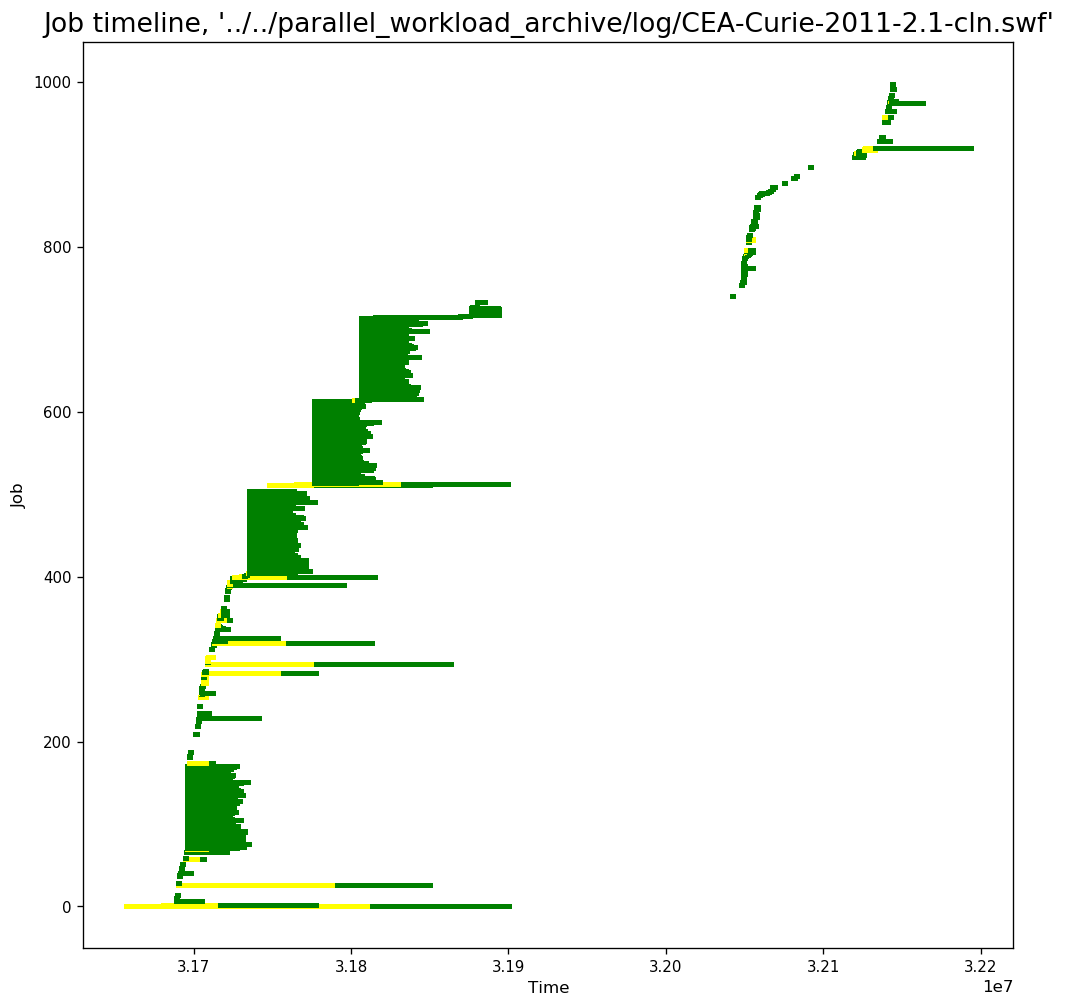

<Figure size 432x288 with 0 Axes>

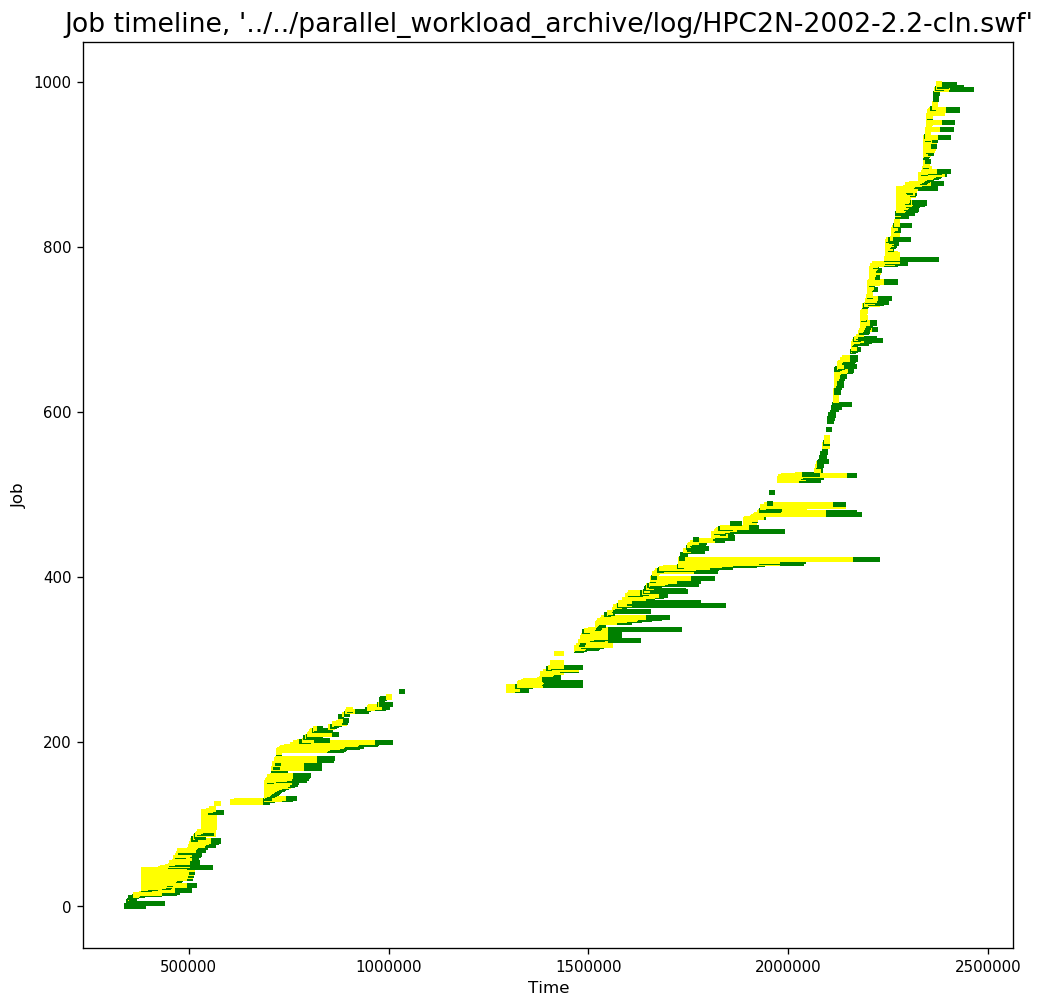

<Figure size 432x288 with 0 Axes>

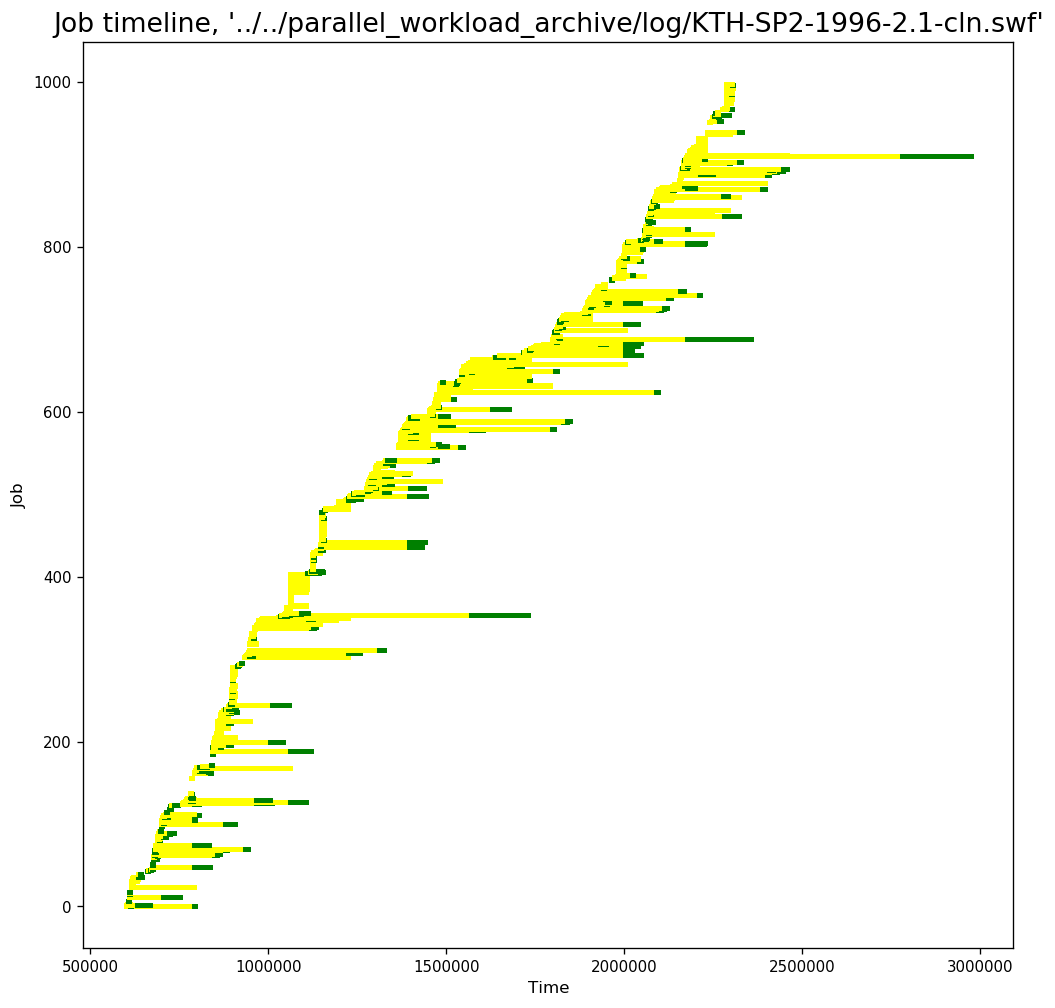

<Figure size 432x288 with 0 Axes>

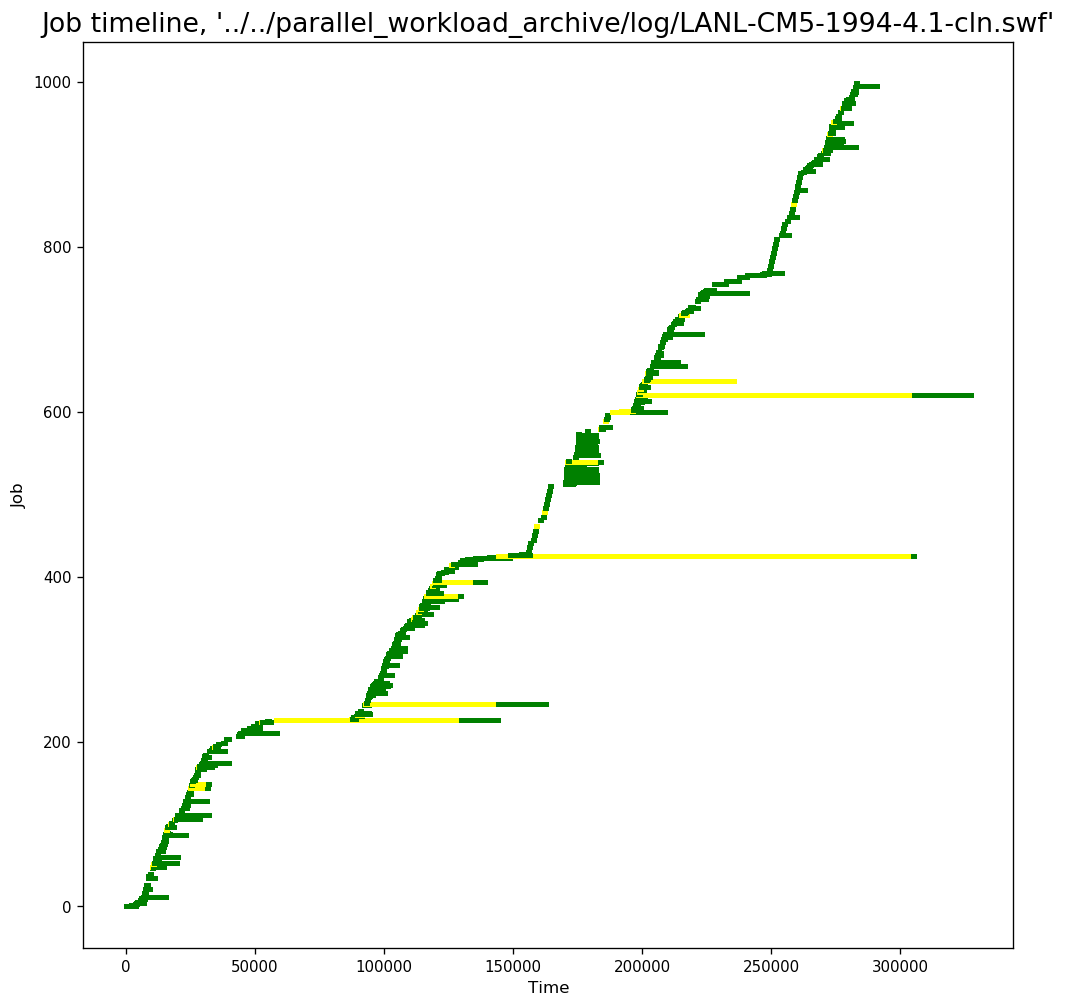

<Figure size 432x288 with 0 Axes>

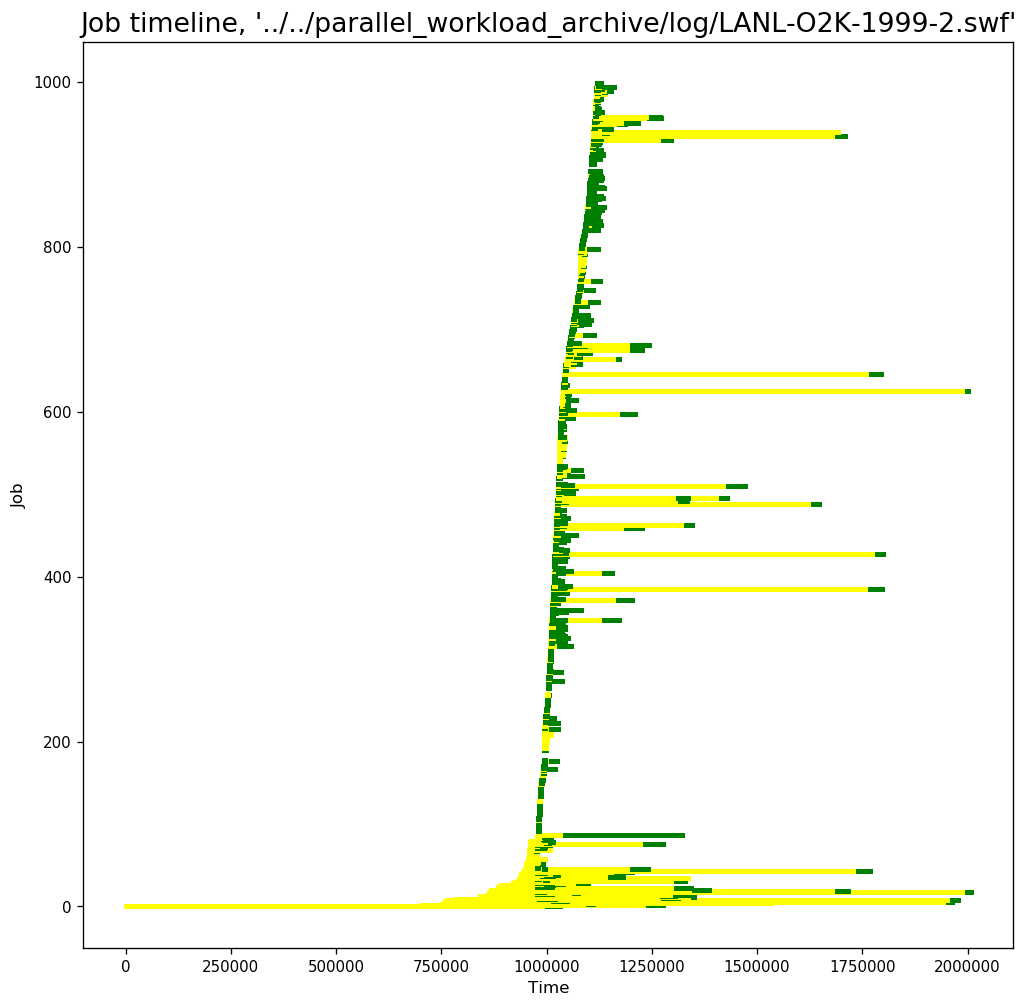

<Figure size 432x288 with 0 Axes>

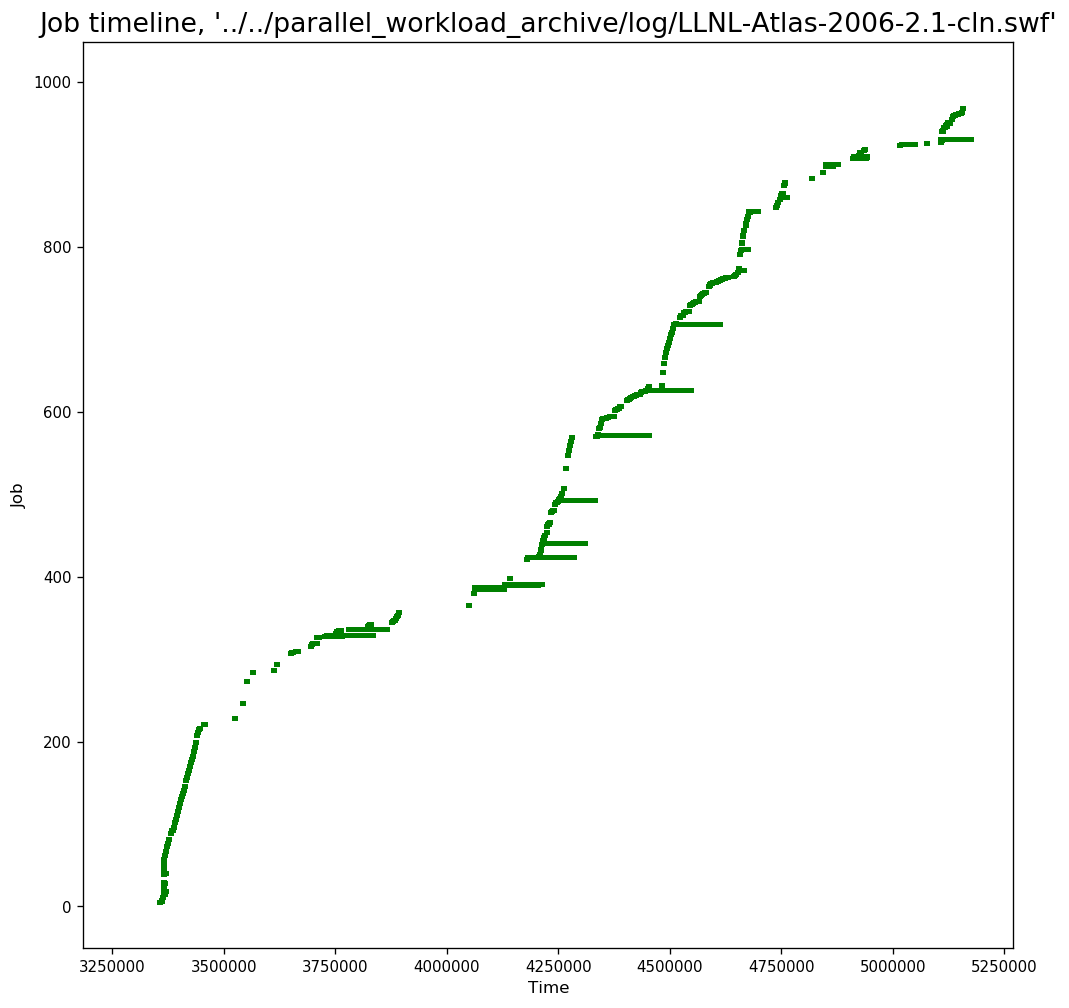

<Figure size 432x288 with 0 Axes>

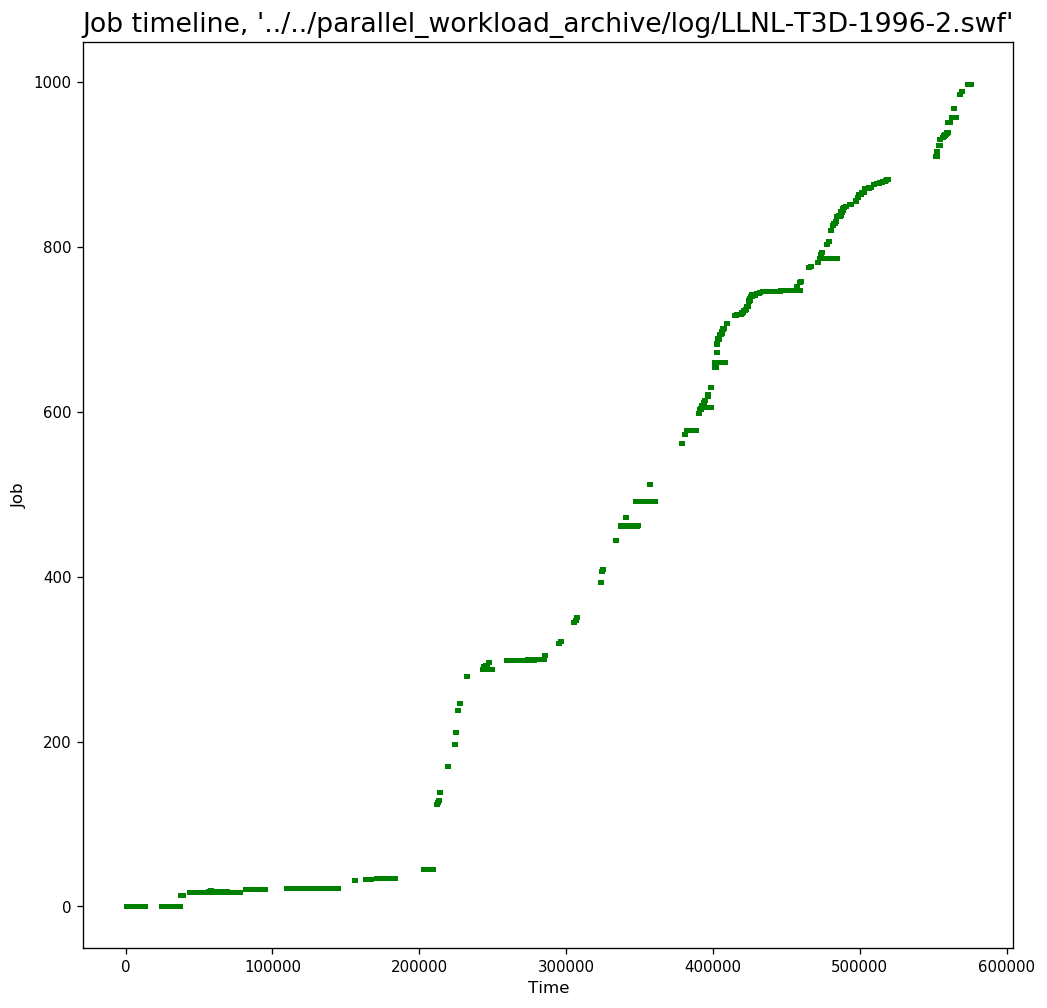

<Figure size 432x288 with 0 Axes>

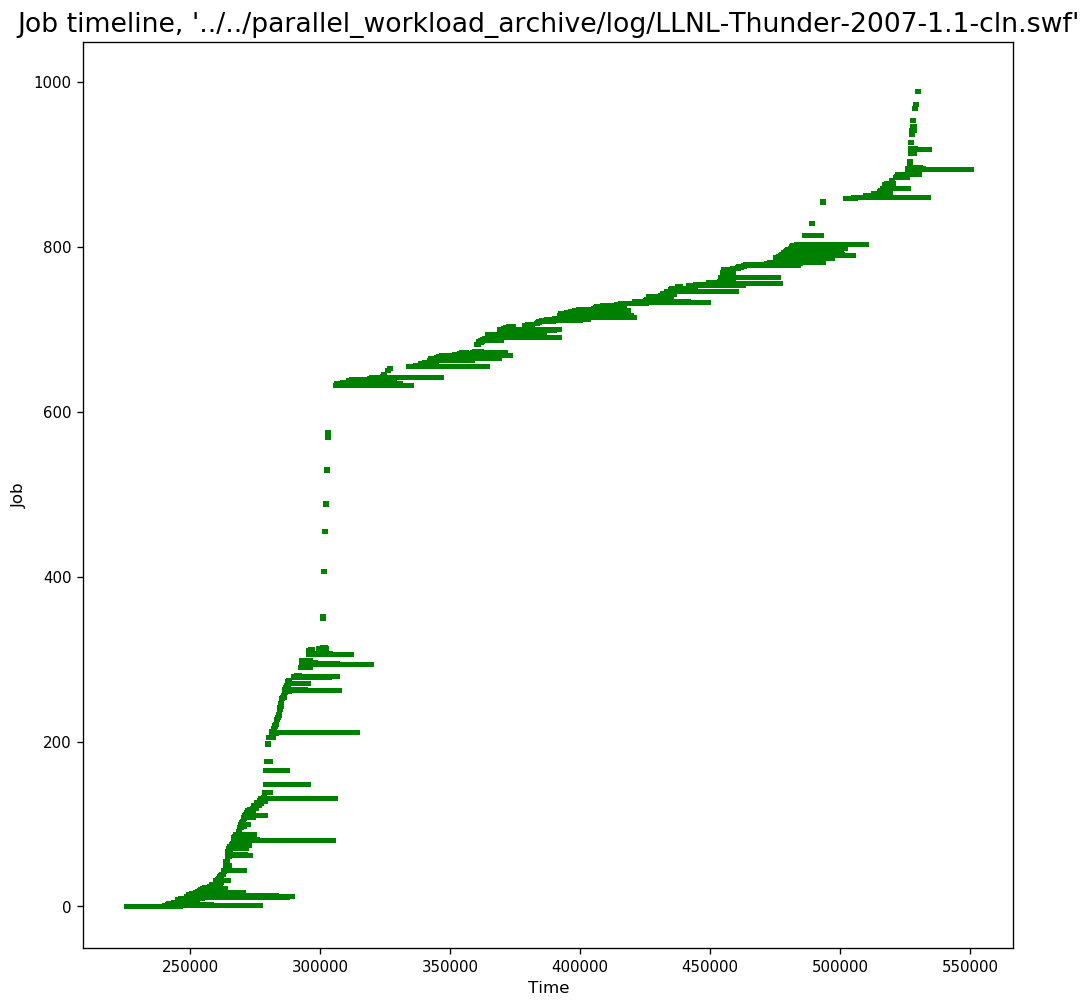

<Figure size 432x288 with 0 Axes>

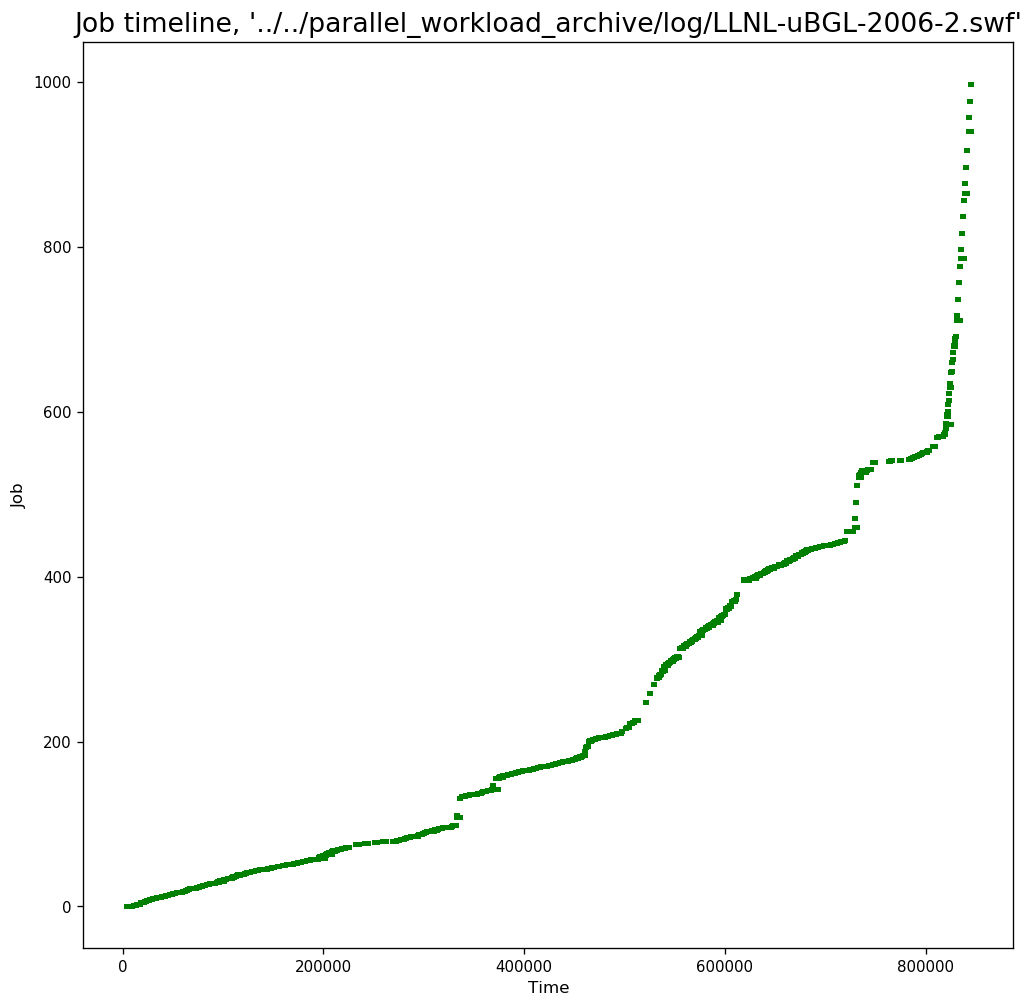

<Figure size 432x288 with 0 Axes>

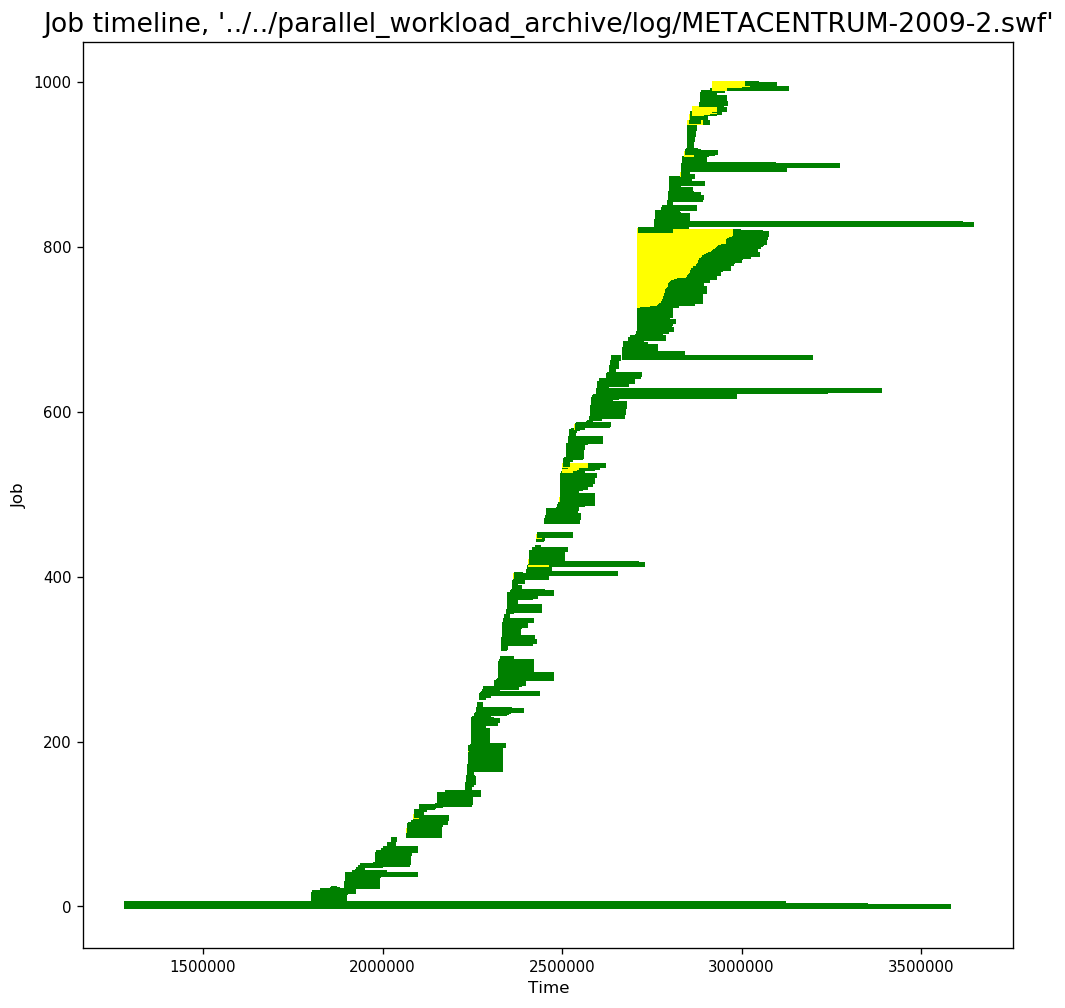

<Figure size 432x288 with 0 Axes>

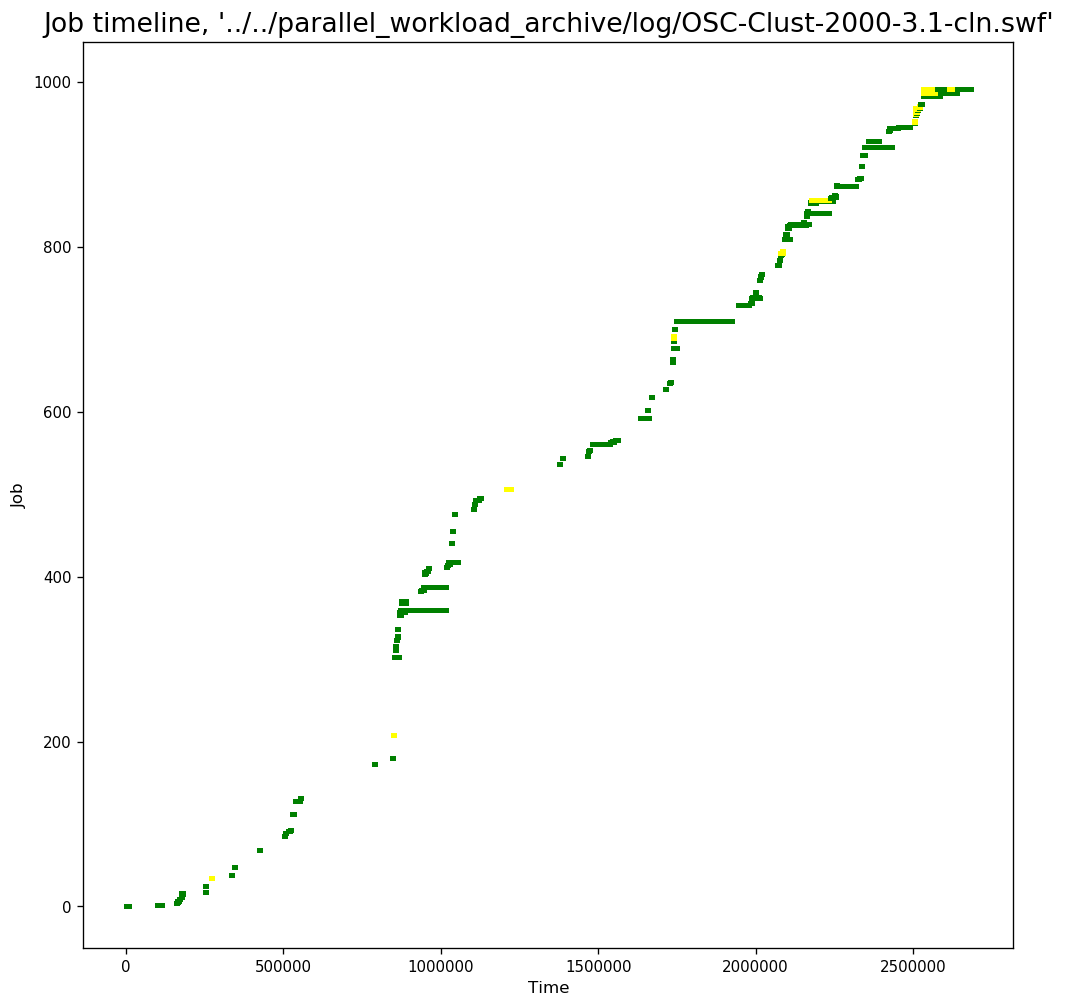

<Figure size 432x288 with 0 Axes>

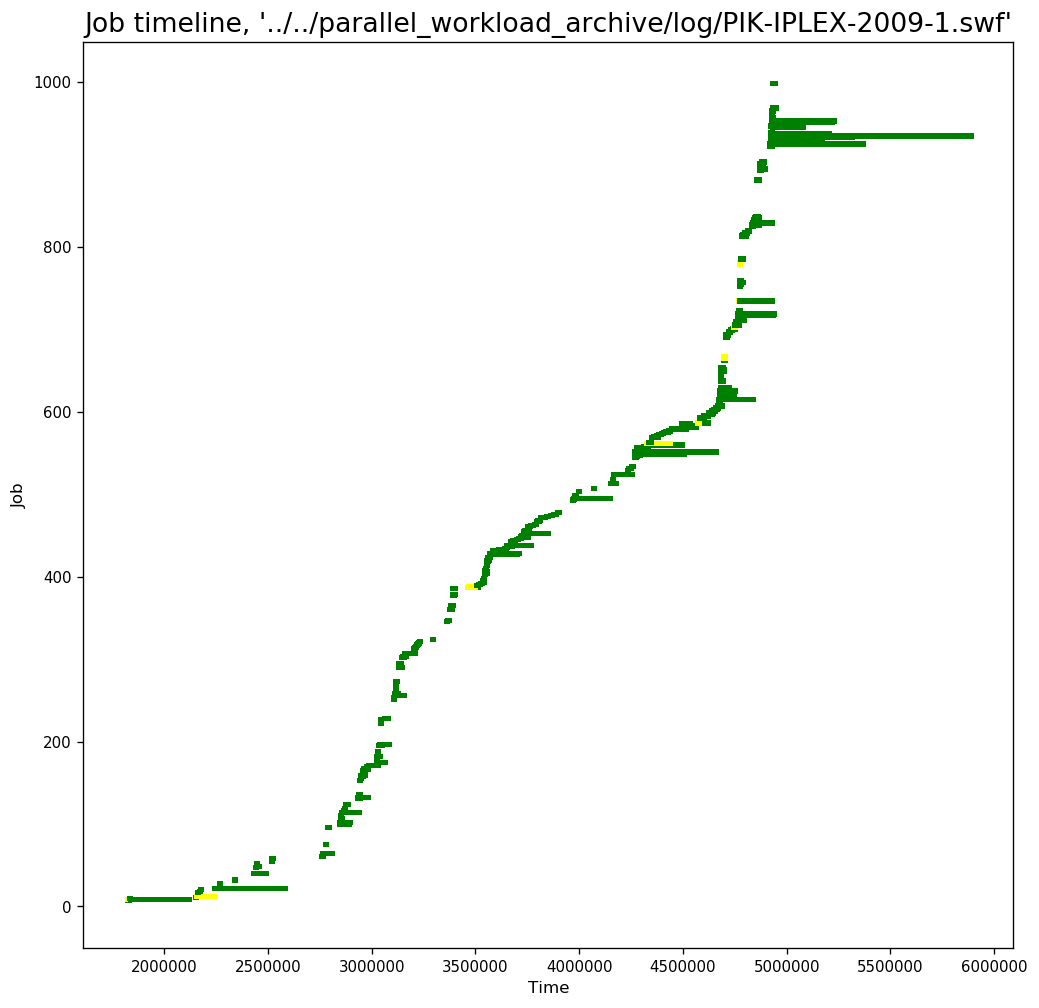

<Figure size 432x288 with 0 Axes>

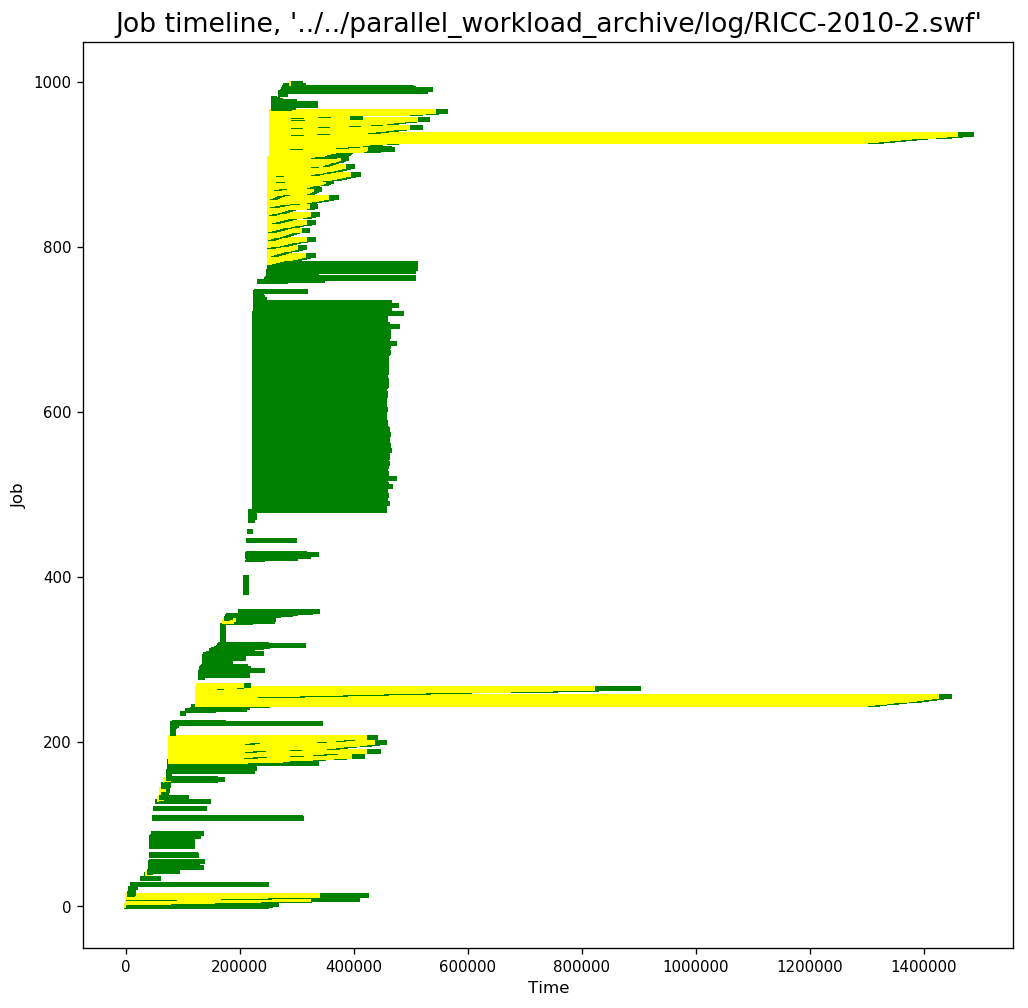

<Figure size 432x288 with 0 Axes>

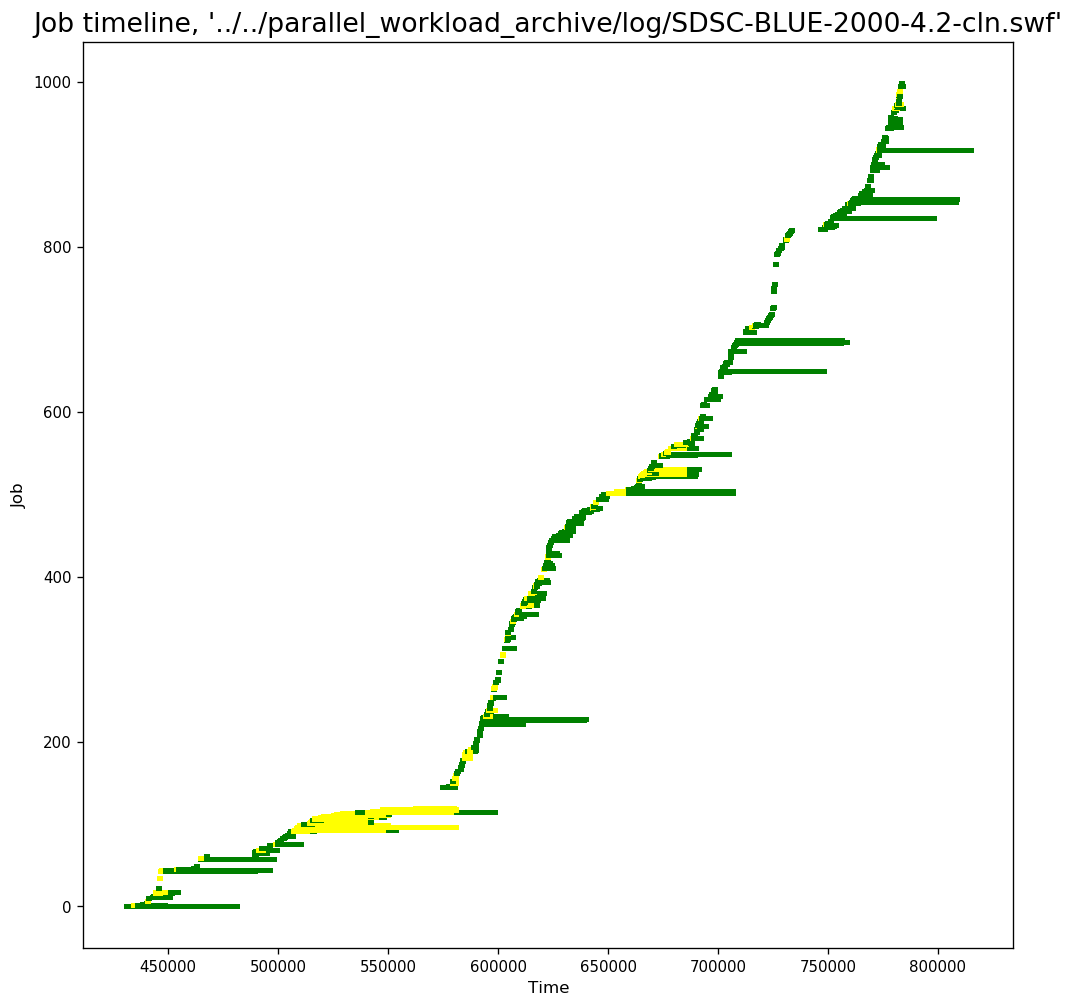

<Figure size 432x288 with 0 Axes>

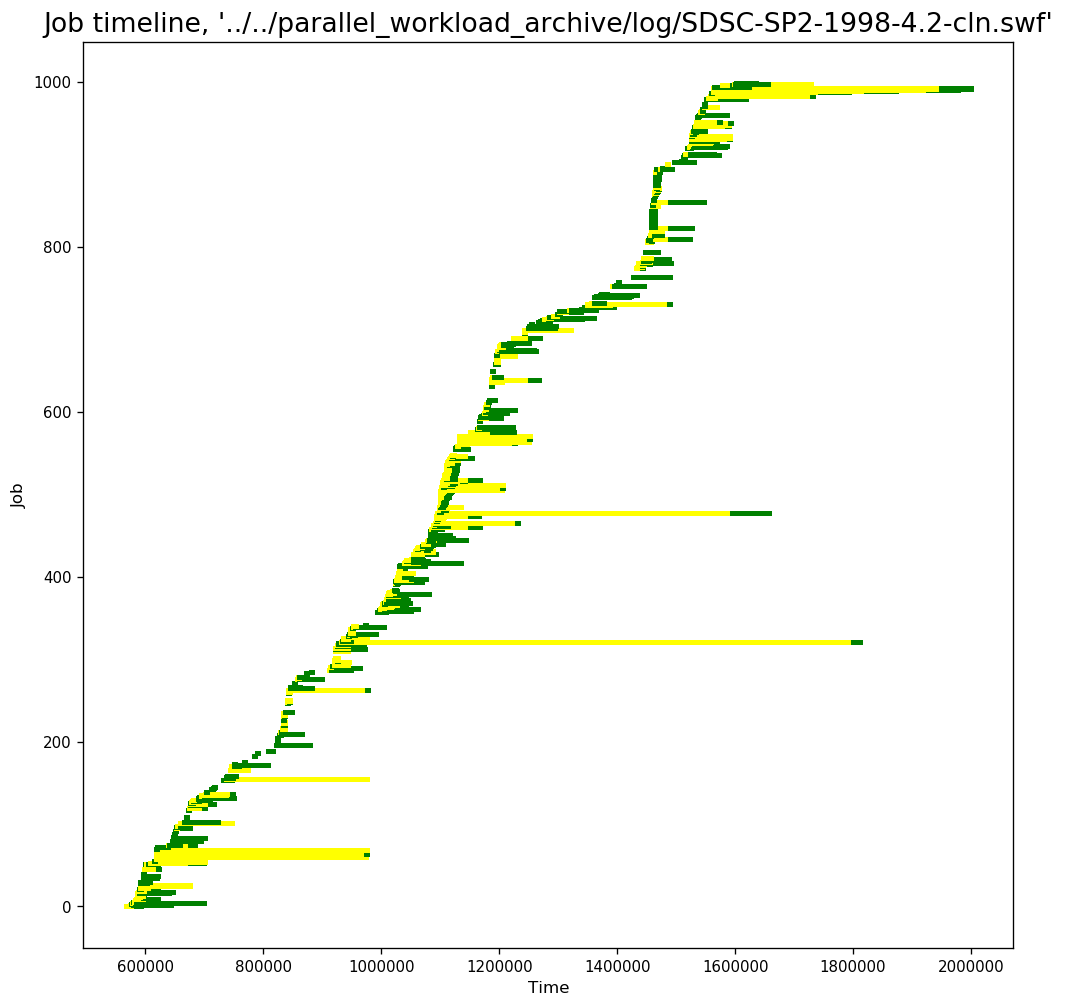

<Figure size 432x288 with 0 Axes>

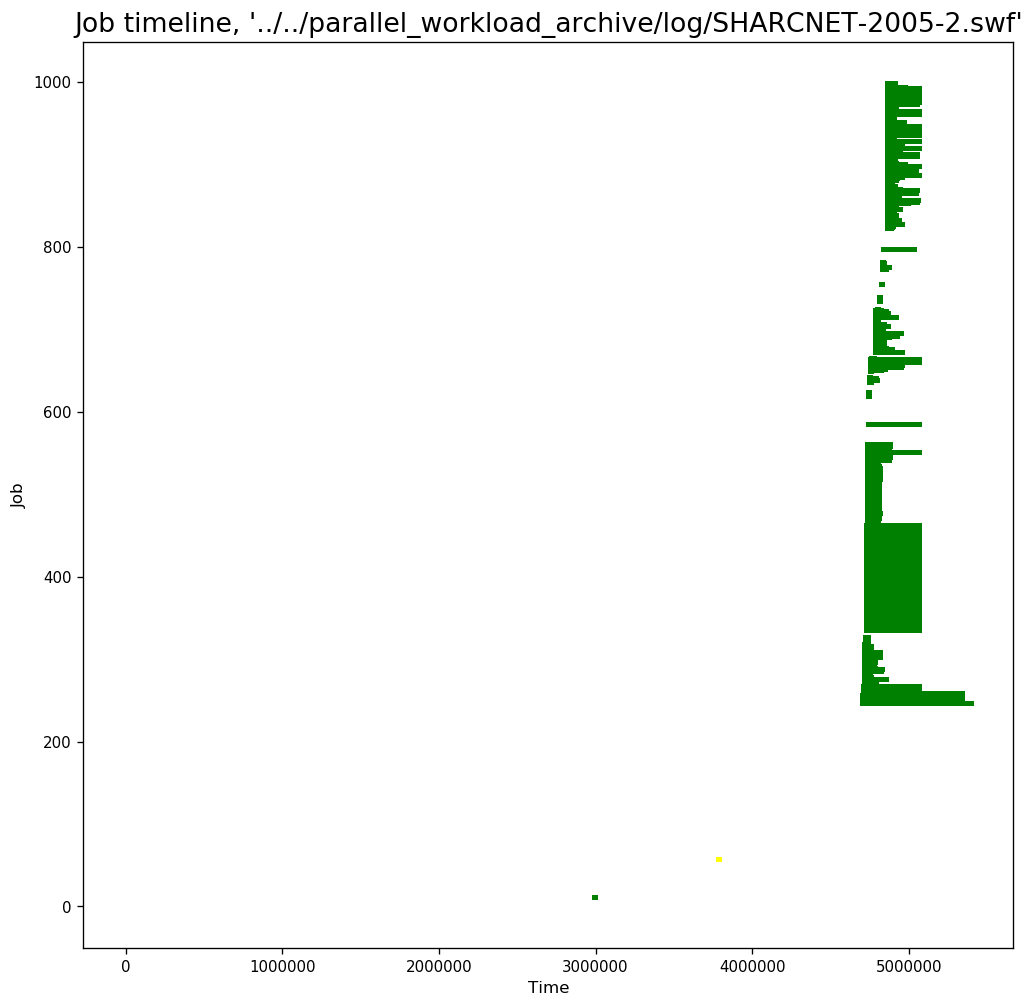

<Figure size 432x288 with 0 Axes>

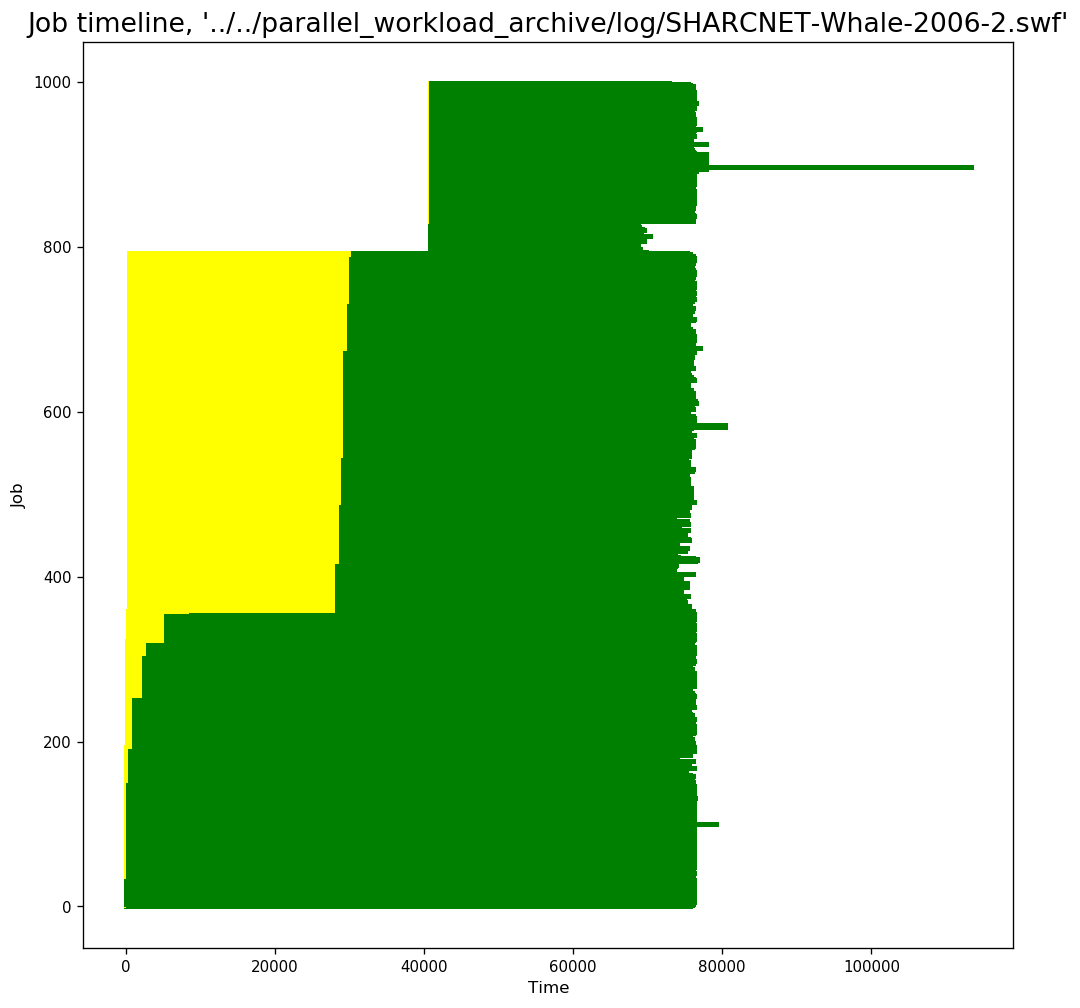

<Figure size 432x288 with 0 Axes>

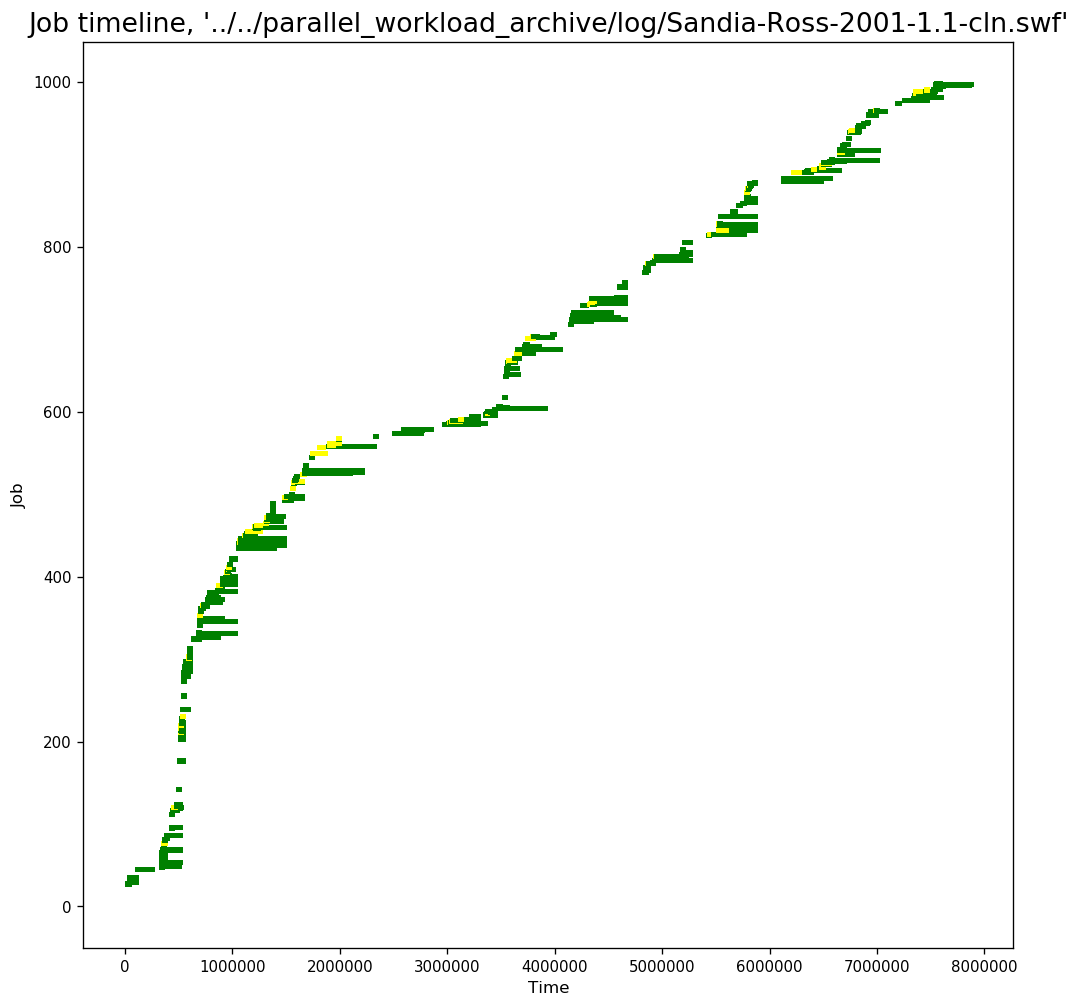

<Figure size 432x288 with 0 Axes>

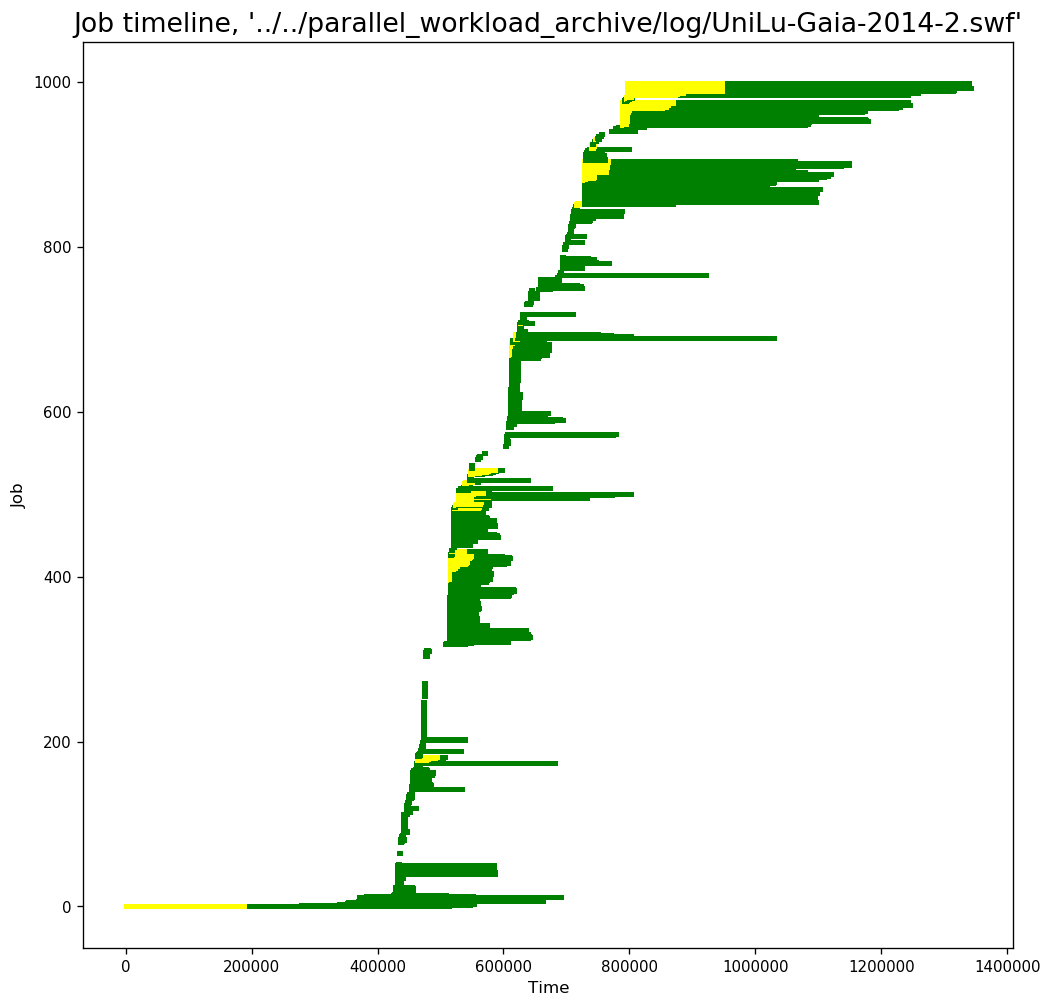

<Figure size 432x288 with 0 Axes>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline


for log_file in LOG_FILES:
    jobs = log_file.jobs
    
    if len(jobs) == 0:
        continue

    fig = plt.figure(figsize=(10,10), dpi=120)
    ax = fig.add_subplot(111)
    plt.title("Job timeline, '%s'" % (log_file.path), fontsize=16)

    for i in range(min(1000, len(jobs))):
        id   = jobs[i].fields["job"]
        sub  = jobs[i].fields["submit"]
        wait = jobs[i].fields["wait"]
        time = jobs[i].fields["runtime"]

        # wait
        X_w = [sub, sub+wait]
        Y_w = np.zeros(len(X_w)) + i

        # run
        X_r = [sub+wait, sub+wait+time]
        Y_r = np.zeros(len(X_r)) + i

        ax.plot(X_w, Y_w, linewidth=3, color="yellow")
        ax.plot(X_r, Y_r, linewidth=3, color="green")

    # Axes, ticks and title configuration
    plt.xlabel("Time", fontsize=10)
    plt.ylabel("Job", fontsize=10)
    plt.tick_params(axis='both', labelsize=9)
    plt.show()

    # Grid configuration
    stepsize = 0.2
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(0, end, stepsize))

    ax.set_axisbelow(True)
    ax.grid(which='both')
    ax.grid(which='major', alpha=0.5)

    # Form legend
    legend_elements = []
    legend_elements.append(
        Line2D([], [], color="yellow", linestyle='-', label="Wait time", markersize=5))
    legend_elements.append(
        Line2D([], [], color="green", linestyle='-', label="Run time", markersize=5))

    # Show figure
    ax.legend(handles=legend_elements)
    plt.tight_layout()
    plt.show()
    # fig.savefig('./job_timeline.png', fmt='png')
    plt.close(fig)

In [ ]:
# Example of mathplotlib usage
# tasks = ["is", "ep", "cg", "lu", "ft"]
# colors = {"is": "red", "ep": "blue", "cg": "orange", "lu": "black", "ft": "cyan"}
# markers = {"is": ".", "ep": "_", "cg": "+", "lu": "x", "ft": "."}

# # Figure configuration
# fig = plt.figure(figsize=(12,30), dpi=300)
# ax = fig.add_subplot(111)
# plt.title('NPB MPI tasks slowdown, size A', fontsize=16)

# # Draw
# for tasks_pair, procs in slowdown_info.items():
#     n = 0
#     for procs_pair, sl in procs.items():
#         task1 = tasks_pair[0]
#         task2 = tasks_pair[1]
#         sl1 = sl[0]
#         sl2 = sl[1]
        
#         ax.plot(n, sl1, color=colors[task1], marker=markers[task1])
#         ax.plot(n, sl2, color=colors[task2], marker=markers[task2])
        
#         n += 1

# # Draw slowdown lines with factor 1 and 2
# null_slowdown_x = np.linspace(0, len(slowdown_info[('is', 'is')].keys())-1, num=2)
# null_slowdown_y = np.zeros(2)
# ax.plot(null_slowdown_x, null_slowdown_y+1, color="red", linestyle=":")

# ax.plot(null_slowdown_x, null_slowdown_y+2, color="red", linestyle=":")

# # Axes configuration
# ax.set_xticks(np.arange(len(slowdown_info[('is', 'is')].keys())))
# ax.set_xticklabels(list(slowdown_info[('is', 'is')].keys()))
# ax.set_xlabel("(np1, np2)")
# ax.set_ylabel("Slowdown (share / pure) [seconds]")


# # Grid configuration
# stepsize = 0.2
# start, end = ax.get_ylim()
# ax.yaxis.set_ticks(np.arange(0, end, stepsize))

# ax.set_axisbelow(True)
# ax.grid(which='both')
# ax.grid(which='major', alpha=0.5)

# # Form legend
# legend_elements = []
# for task in tasks:
#     legend_elements.append(
#         Line2D([], [], marker=markers[task], color=colors[task], linestyle='None', label=task, markersize=10))

# # Show figure
# ax.legend(handles=legend_elements)
# plt.tight_layout()
# plt.show()
# fig.savefig('./slowdown_size_A.png', fmt='png')
# plt.close(fig)

../../parallel_workload_archive/log/ANL-Intrepid-2009-1.swf
../../parallel_workload_archive/log/CEA-Curie-2011-2.1-cln.swf
{
    "279991": 1
}
[279991] [1]
../../parallel_workload_archive/log/HPC2N-2002-2.2-cln.swf
{
    "201993": 1
}
[201993] [1]
../../parallel_workload_archive/log/KTH-SP2-1996-2.1-cln.swf
{
    "20523": 1
}
[20523] [1]
../../parallel_workload_archive/log/LANL-CM5-1994-4.1-cln.swf
{
    "2": 446,
    "16159": 1,
    "450": 1,
    "1316": 1,
    "19": 29,
    "47": 6,
    "3094": 1,
    "14": 30,
    "20": 17,
    "12": 45,
    "3419": 1,
    "738": 1,
    "2721": 1,
    "959": 1,
    "955": 1,
    "6": 144,
    "34": 11,
    "178": 1,
    "36": 10,
    "1559": 1,
    "26": 10,
    "1": 1354,
    "9": 74,
    "10": 60,
    "23": 17,
    "268": 1,
    "115": 1,
    "28": 13,
    "1488": 1,
    "35": 6,
    "49": 2,
    "85": 2,
    "137": 1,
    "637": 1,
    "30": 13,
    "66": 5,
    "11": 43,
    "31": 10,
    "46": 8,
    "40": 10,
    "5": 189,
    "13": 41,
    "2

../../parallel_workload_archive/log/LLNL-T3D-1996-2.swf
{
    "38": 2,
    "201": 1,
    "33": 2,
    "3": 58,
    "5": 26,
    "1": 174,
    "36": 1,
    "868": 1,
    "2": 95,
    "14": 6,
    "160": 1,
    "4": 29,
    "8": 18,
    "9": 13,
    "10": 14,
    "117": 1,
    "26": 3,
    "13": 4,
    "7": 12,
    "12": 9,
    "11": 11,
    "277": 1,
    "1453": 1,
    "27": 3,
    "18": 5,
    "6": 25,
    "532": 1,
    "21": 4,
    "65": 1,
    "59": 1,
    "52": 1,
    "19": 5,
    "343": 1,
    "16": 3,
    "43": 1,
    "83": 2,
    "216": 1,
    "40": 1,
    "24": 3,
    "101": 1,
    "30": 4,
    "32": 3,
    "95": 1,
    "17": 3,
    "15": 6,
    "582": 1,
    "106": 1,
    "672": 1,
    "25": 1,
    "29": 1,
    "235": 1,
    "55": 1,
    "88": 1,
    "31": 2,
    "44": 1,
    "45": 1,
    "35": 3,
    "47": 3,
    "430": 1,
    "214": 1,
    "115": 1,
    "136": 1,
    "74": 1,
    "63": 1,
    "82": 1,
    "39": 2,
    "20": 1,
    "91": 1,
    "72": 1,
    "28": 2,
    "124":

{
    "431547": 1
}
[431547] [1]
../../parallel_workload_archive/log/SDSC-BLUE-2000-4.2-cln.swf
{
    "195582": 1
}
[195582] [1]
../../parallel_workload_archive/log/SDSC-SP2-1998-4.2-cln.swf
{
    "1": 38411,
    "22": 3,
    "21": 2,
    "48": 2,
    "3": 76,
    "2": 118,
    "4": 24,
    "6": 21,
    "153": 1,
    "15": 4,
    "274": 1,
    "23": 1,
    "93": 1,
    "20": 2,
    "7": 9,
    "5": 23,
    "85": 1,
    "25": 1,
    "8": 15,
    "31": 1,
    "57": 1,
    "76": 1,
    "55": 1,
    "42": 1,
    "12": 7,
    "52": 1,
    "16": 2,
    "13": 3,
    "38": 1,
    "206": 1,
    "141": 1,
    "75": 1,
    "258": 1,
    "27": 1,
    "51": 1,
    "45": 1,
    "68": 1,
    "80": 1,
    "36": 1,
    "37": 1,
    "35": 1,
    "290": 1,
    "14": 2,
    "19": 1,
    "496": 1,
    "10": 5,
    "246": 1,
    "11": 4,
    "9": 3
}
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 25, 27, 31, 35, 36, 37, 38, 42, 45, 48, 51, 52, 55, 57, 68, 75, 76, 80, 85, 93, 141

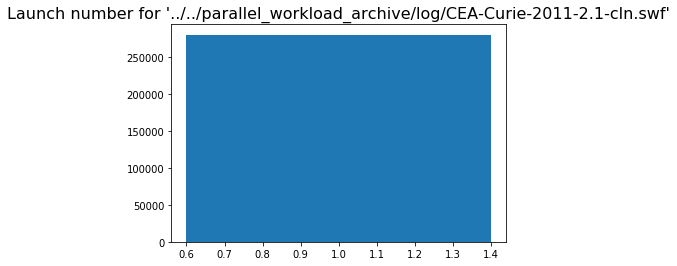

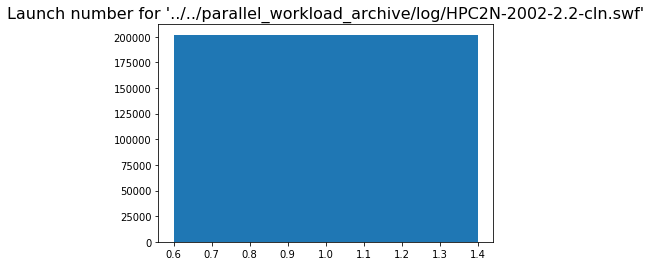

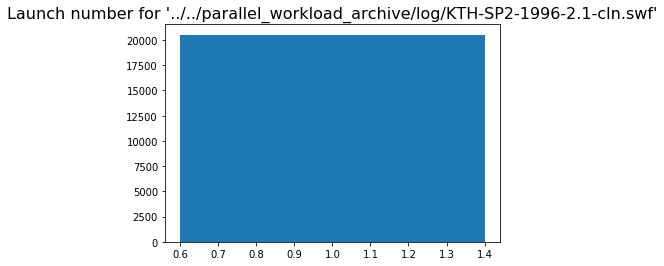

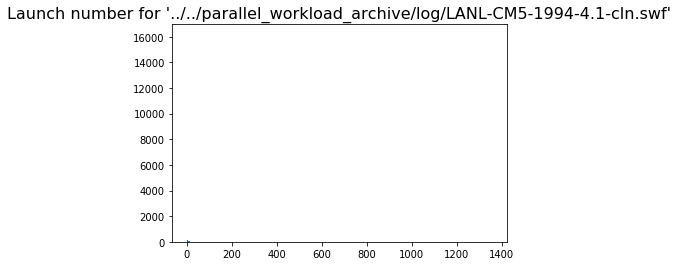

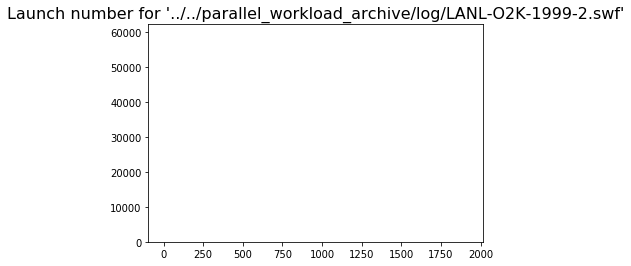

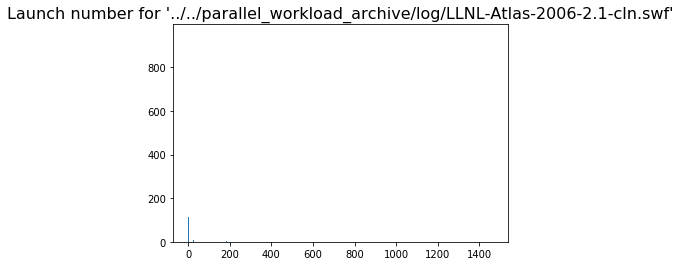

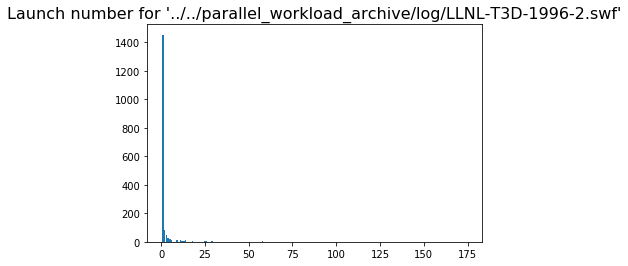

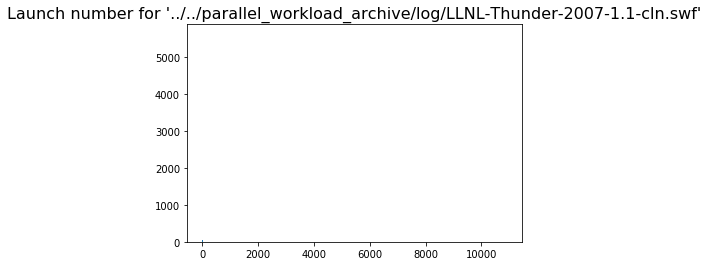

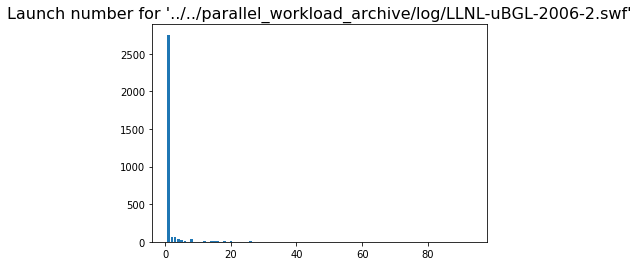

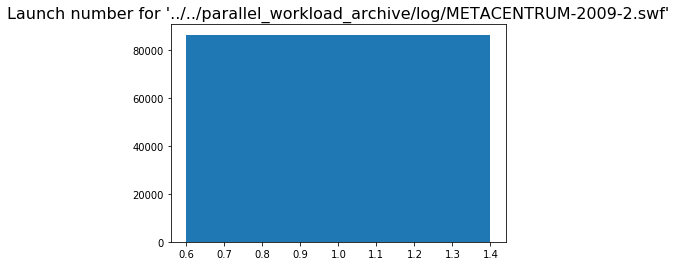

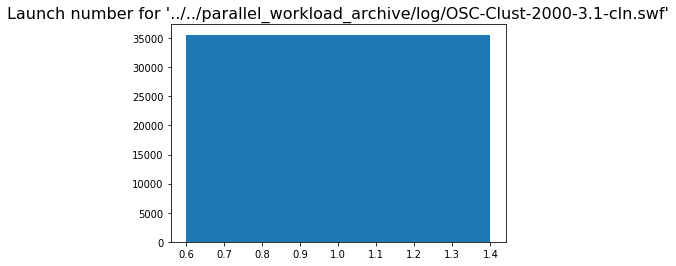

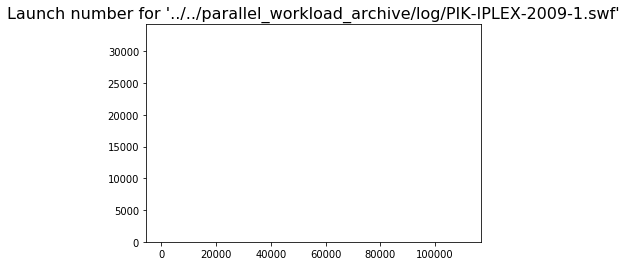

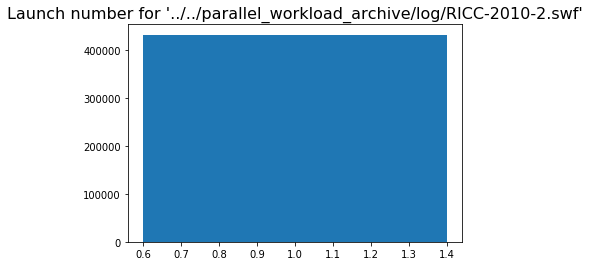

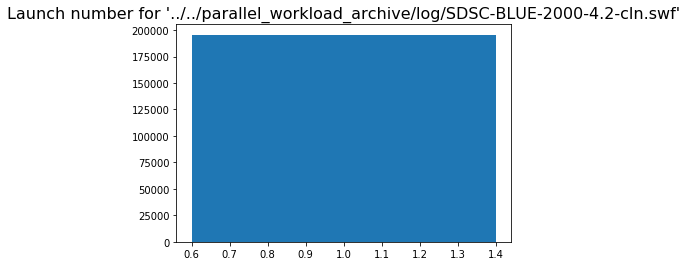

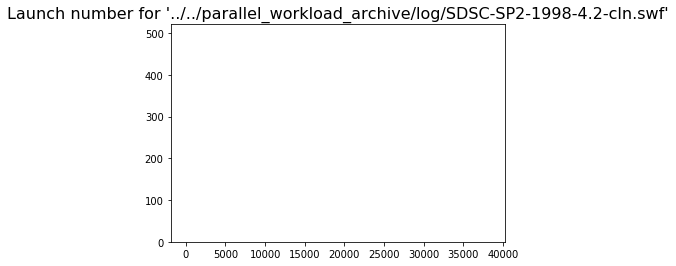

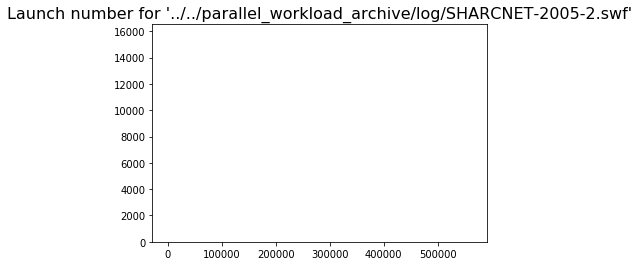

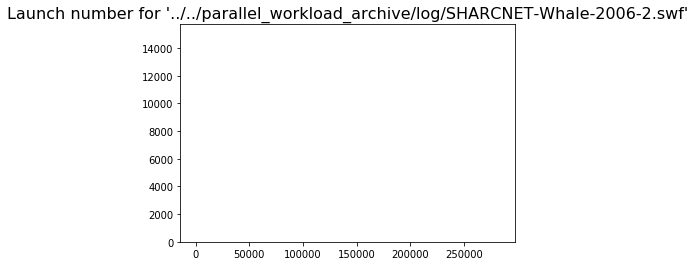

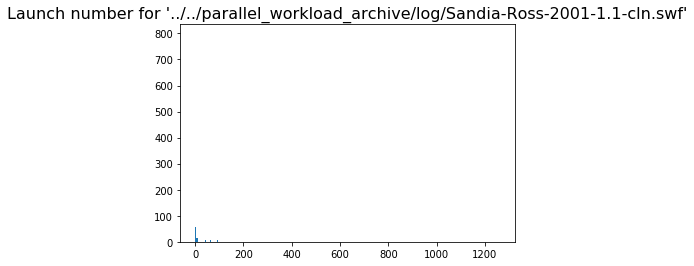

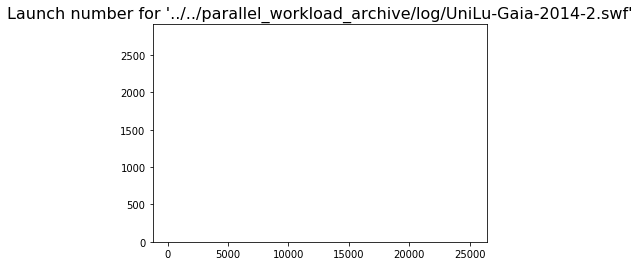

In [11]:
import json

for i in range(len(LOG_FILES)):
    log_file = LOG_FILES[i]
    
    print(log_file.path)
    
    if len(log_file.jobs) == 0:
        continue
    
    job_stats = {}
    for job in log_file.jobs:
        if job.fields["executable"] not in job_stats:
            job_stats[job.fields["executable"]] = 0
        job_stats[job.fields["executable"]] += 1
    
    launch_number = {}
    for job_id, amount in job_stats.items():
        if amount not in launch_number:
            launch_number[amount] = 0
        launch_number[amount] += 1

    print(json.dumps(launch_number, indent=4))
#     fig = plt.figure(figsize=(5,5), dpi=120)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title("Launch number for '%s'" % (log_file.path), fontsize=16)

    Y = sorted(list(launch_number.keys()))
    X = [launch_number[y] for y in Y]
    
    print(Y, X)

# #     ax.plot(X, Y, linewidth=2, color="green")
    ax.bar(X,Y)

#     # Grid configuration
#     stepsize = 0.2
#     start, end = ax.get_ylim()
#     ax.yaxis.set_ticks(np.arange(0, end, stepsize))
    
#     # Axes configuration
#     ax.set_xticks(np.arange(len(X)))
#     ax.set_xticklabels(sorted(X))
#     ax.set_xlabel("Launches", fontsize=10)
#     ax.set_ylabel("Slowdown (share / pure) [seconds]", fontsize=10)

#     ax.set_axisbelow(True)
#     ax.grid(which='both')
#     ax.grid(which='major', alpha=0.5)

#     print("Test 1")
    
#     # Show figure
#     plt.tight_layout()
#     plt.show()
    
#     print("Test 2")
#     # fig.savefig('./job_timeline.png', fmt='png')
# #     plt.close(fig)
    
# #     break


print("Well done!!!")

In [ ]:
N_points = 100000
n_bins = 30

# Generate a normal distribution, center at x=0 and y=5
x = np.random.randn(N_points)
y = .4 * x + np.random.randn(100000) + 5

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x, bins=n_bins)
axs[1].hist(y, bins=n_bins)
